# IT1244: Traffic Sing Classifer using neural networks


Image classification has always been an important topic that often increased efficiency and productivity of systems they are implemented in.  The number of fatal traffic accidents increased by 26% from 2022 to 2023 and surpassed pre-COVID level cases in 2019. 

As the number of drivers on the road has increased over the years, the need to improve safety on the road has become more urgent. 

Traffic signs are essential components of road systems, providing critical information to control, guide, and warn drivers. With  strides in computer vision and artificial intelligence, traffic sign classification has become a prominent research focus, with large potential ramifications for traffic safety.

In [53]:
# Standard libraries
import os
import random
import json
import shutil
from collections import Counter, defaultdict

# Third-party libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics import f1_score

# TensorFlow and Keras
import keras
import tensorflow as tf
from keras import ops
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam



In [109]:
def display_batch(images, labels, num_images=64):
    """
    Displays a grid of images with their corresponding labels.

    Parameters:
    - images (list or numpy.ndarray): List or array of images to display.
    - labels (list): List of labels corresponding to each image.
    - num_images (int, optional): Number of images to display (default is 64).
    """
    plt.figure(figsize=(12, 12))
    grid_size = int(num_images**0.5) 
    
    for i in range(num_images):
        ax = plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(images[i])  
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

def organise_images_by_class(image_directory, parent_directory):
    """
    Organizes images into subdirectories based on their class names derived from the filenames.

    Parameters:
    - image_directory (str): Path to the directory containing the images.
    - parent_directory (str): Path to the parent directory where class subdirectories will be created.
    """
    classes = set()
    for image in os.listdir(image_directory):
        classes.add(image[:2])

    newlist = []
    for classname in list(classes):
        newstring = ""
        for char in classname:
            if char.isnumeric():
                newstring += char
        newlist.append(int(newstring))

    for num in newlist:
        dir_path = os.path.join(parent_directory, str(num))
        os.makedirs(dir_path, exist_ok=True)
        print(f"Directory {dir_path} created.")

    for imagefilename in os.listdir(image_directory):
        newstring = ""
        for char in imagefilename[:2]:
            if char.isnumeric():
                newstring += char
        targetdirectory = os.path.join(parent_directory, newstring)
        newimagepath = os.path.join(image_directory, imagefilename)
        shutil.move(newimagepath, targetdirectory)
        print(f"Image {imagefilename} moved to {targetdirectory}.")



def plot_number_of_images(file_path):
    """
    Plots the number of images in each class from the dataset directory.

    Parameters:
    - file_path (str): Path to the dataset directory containing class subdirectories.
    """
    dataset_directory = file_path
    class_counts = []

    for i in range(23):
        class_folder = os.path.join(dataset_directory, str(i))
        if os.path.isdir(class_folder):
            image_count = len([f for f in os.listdir(class_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])
            class_counts.append(image_count)
        else:
            class_counts.append(0)

    class_labels = [str(i) for i in range(23)]

    plt.figure(figsize=(10, 6))
    plt.bar(class_labels, class_counts, color='skyblue')
    plt.xlabel('Class Labels (0 to 22)')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Class')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    plt.tight_layout()
    plt.show()

def even_out_class_size(dataset_directory, balanced_directory):
    """
    Balances the number of images across classes by taking a random sample of images,
    sample size=median image count by class

    Parameters:
    - dataset_directory (str): Path to the directory containing the original class subdirectories.
    - balanced_directory (str): Path to the directory where balanced class subdirectories will be created.
    """
    os.makedirs(balanced_directory, exist_ok=True)

    class_counts = []
    class_folders = []

    for i in range(23):
        class_folder = os.path.join(dataset_directory, str(i))
        if os.path.isdir(class_folder):
            image_files = [f for f in os.listdir(class_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
            class_counts.append(len(image_files))
            class_folders.append(class_folder)

    median_count = int(np.median(class_counts))
    target_count = median_count
    print(f"Median image count: {median_count}")

    final_class_counts = []
    for class_folder in class_folders:
        class_images = [f for f in os.listdir(class_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
        if len(class_images) > target_count:
            selected_images = random.sample(class_images, target_count)
            final_class_counts.append(target_count)
        else:
            selected_images = class_images
            final_class_counts.append(len(selected_images))

        target_class_folder = os.path.join(balanced_directory, os.path.basename(class_folder))
        os.makedirs(target_class_folder, exist_ok=True)
        for image in selected_images:
            shutil.copy(os.path.join(class_folder, image), os.path.join(target_class_folder, image))


def top_up_images(balanced_directory, end_image_count=400):
    """
    Augments images in each class folder to ensure a minimum number of images (400) per class.

    Parameters:
    - balanced_directory (str): Path to the directory containing class subdirectories with images.
    - end_image_count(int): Target number of images you want in each directory.
    """
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.2),                    
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomBrightness(0.2),
        tf.keras.layers.GaussianNoise(0.2)
    ])

    for class_folder in os.listdir(balanced_directory):
        target_class_folder = os.path.join(balanced_directory, class_folder)
        current_count = len(os.listdir(target_class_folder))
        
        while current_count < end_image_count:
            for image_name in os.listdir(target_class_folder):
                image_path = os.path.join(target_class_folder, image_name)
                image = tf.keras.utils.load_img(image_path)
                image = tf.keras.utils.img_to_array(image)
                
                augmented_image = data_augmentation(tf.expand_dims(image, axis=0))
                augmented_image = tf.squeeze(augmented_image).numpy()
                augmented_image_path = os.path.join(target_class_folder, f"aug_{current_count}_{image_name}")
                tf.keras.utils.save_img(augmented_image_path, augmented_image)
                current_count += 1
                
                if current_count >= end_image_count:
                    break


def load_and_remap_and_normalise_dataset(data_path, image_size=(128, 128), batch_size=256, seed=42, shuffle=True):
    """
    Loads, remaps, and normalizes a dataset of images from a directory, from lexicographically ordered labels to 
    numerically sorted in ascending order

    Parameters:
    - data_path (str): Path to the directory containing image subdirectories.
    - image_size (tuple): Target size for the images (default is (128, 128)).
    - batch_size (int): Number of images to return in each batch (default is 256).
    - seed (int): Random seed for shuffling (default is 42).
    - shuffle (bool): Whether to shuffle the dataset (default is True).

    Returns:
    - tf.data.Dataset: A dataset object containing normalized images and remapped labels.
    """
    lexicographical_order_list = [0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 3, 4, 5, 6, 7, 8, 9]

    data = tf.keras.utils.image_dataset_from_directory(
        data_path,
        image_size=image_size,
        batch_size=batch_size,
        seed=seed,
        label_mode="int",
        shuffle=shuffle
    )

    def remap_labels(images, labels):
        new_labels = tf.gather(lexicographical_order_list, labels)
        return images, new_labels

    data = data.map(remap_labels)
    data=data.map(lambda x,y: (x/255,y))
    return data

def plot_loss_and_accuracy(hist):
    """
    Plots the training and validation loss and accuracy over epochs.

    Parameters:
    - hist: History object returned by model.fit(), containing loss and accuracy metrics.

    Returns:
    - None: Displays loss and accuracy plots.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].plot(hist['loss'], color='teal', label='Loss')
    axes[0].plot(hist['val_loss'], color='orange', label='Val Loss')
    axes[0].set_title('Loss', fontsize=16)
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss Value')
    axes[0].legend(loc="upper left")
    
    axes[1].plot(hist['accuracy'], color='teal', label='Accuracy')
    axes[1].plot(hist['val_accuracy'], color='orange', label='Val Accuracy')
    axes[1].set_title('Accuracy', fontsize=16)
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy Value')
    axes[1].legend(loc="upper left")

    plt.tight_layout()
    plt.show()

def count_classes_in_sampled_batches(dataset, num_batches=9, plot=True):
    """
    Count the occurrences of each class in a sampled number of batches of the dataset.

    Parameters:
    - dataset: A TensorFlow dataset object containing images and labels.
    - num_batches: Number of batches to sample (default is 9).
    - plot: A boolean indicating whether to plot the counts (default is True).

    Returns:
    - batch_counts: A list of Counter objects with counts for each sampled batch.
    """
    batch_counts = []
    for i, (images, labels) in enumerate(dataset):
        if i >= num_batches:  
            break
        label_counts = Counter(labels.numpy())
        batch_counts.append(label_counts)

    if plot:
        all_classes = sorted(set().union(*[counts.keys() for counts in batch_counts]))
        
        fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
        axs = axs.flatten()

        for batch_index, counts in enumerate(batch_counts):
            counts_values = [counts.get(cls, 0) for cls in all_classes]
     
            axs[batch_index].bar(all_classes, counts_values, color='skyblue')
            axs[batch_index].set_title(f'Batch {batch_index + 1}')
            axs[batch_index].set_xlabel('Classes')
            axs[batch_index].set_ylabel('Count of Images')
            axs[batch_index].set_xticks(all_classes) 
            axs[batch_index].set_xticklabels(all_classes, rotation=45)

        plt.tight_layout()
        plt.suptitle(f'Distribution of Classes Across {num_batches} Sampled Batches', fontsize=16)
        plt.subplots_adjust(top=0.9) 

        plt.show()

    return batch_counts


def evaluate_model_for_specific_classes(model, test_dataset, class_1=6, class_2=10):
    """
    Evaluates the model on the test dataset and calculates false negative rates for the specified classes.

    Parameters:
        model: The trained model to evaluate.
        test_dataset: The dataset used for testing, yielding images and corresponding labels.
        class_1: The first class of interest.
        class_2: The second class of interest.

    Returns:
        dict: A dictionary with false negative rates for each specified class, test loss, and test accuracy.
    """
    y_true = []
    y_pred = []
    
    for images, labels in test_dataset:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1)) 
        y_true.extend(labels.numpy()) 
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    false_negative_rates = {}

    for class_of_interest in [class_1, class_2]:
        false_negatives = np.sum((y_true == class_of_interest) & (y_pred != class_of_interest))
        total_positives = np.sum(y_true == class_of_interest)
        
        false_negative_rate = false_negatives / total_positives if total_positives > 0 else 0
        false_negative_rates[class_of_interest] = false_negative_rate
    
    test_loss, test_acc = model.evaluate(test_dataset)
    print(f"Test accuracy: {test_acc:.4f}")

    return false_negative_rates, test_loss, test_acc

from sklearn.metrics import f1_score

def get_misclassifications(model, dataset, class_names = [str(i) for i in range(23)] , verbose=1):
    misclassification_dicts = {}
    all_predictions = []
    all_labels = []

    for images, labels in dataset:
        predictions = model.predict(images, verbose=0)
        all_predictions.extend(predictions)
        all_labels.extend(labels.numpy())

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    pred_classes = np.argmax(all_predictions, axis=1)
    true_classes = all_labels.astype(int)

    # Identify misclassifications
    misclassified_idx = np.where(pred_classes != true_classes)[0]
    misclassifications = []

    for idx in misclassified_idx:
        true_class_name = class_names[true_classes[idx]]
        pred_class_name = class_names[pred_classes[idx]]

        if true_class_name not in misclassification_dicts:
            misclassification_dicts[true_class_name] = {}
        if pred_class_name not in misclassification_dicts[true_class_name]:
            misclassification_dicts[true_class_name][pred_class_name] = 0
        misclassification_dicts[true_class_name][pred_class_name] += 1

        misclassifications.append([
            class_names[true_classes[idx]],  
            class_names[pred_classes[idx]],  
            f"{np.max(all_predictions[idx]) * 100:.2f}%"  
        ])

    f1_scores = {}
    for class_of_interest in [6, 10]:
        f1 = f1_score(true_classes, pred_classes, labels=[class_of_interest], average='macro', zero_division=0)
        f1_scores[class_of_interest] = f1


    # Calculate simple accuracy: correct predictions / total predictions
    correct_predictions = np.sum(pred_classes == true_classes)
    total_predictions = len(true_classes)
    accuracy = correct_predictions / total_predictions

    if verbose == 1:
        print("Misclassification counts:")
        print(misclassification_dicts)
        """
        print("\nDetailed misclassifications:")
        for item in misclassifications:
            print(item)
        """
        print("\nF1 Score:")
        print(f1_scores)
        print("\nAccuracy:")
        print(f"{accuracy:.2f}")
        print("\n Number of Misclassifications: ")
        print(len(misclassified_idx))

    return misclassifications, f1, accuracy



### Create Image split by class

Pull original images folder into the same level as the expermimental folder, folder structure should look like this:

- IT1244_project
  - experimentl
  - images
  - src




In [ ]:
organise_images_by_class(image_directory="../images", parent_directory="../experimental/data_classes")

### Plot of original class distribution between classes

As we can see, class 0 to 23 is actually sorted in descending order of number of images

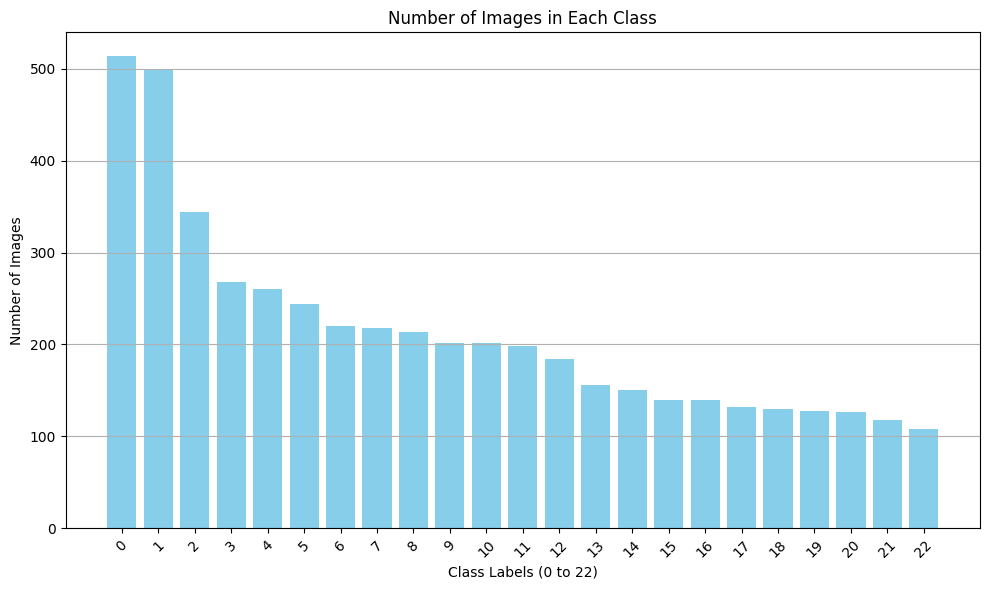

In [117]:
plot_number_of_images(file_path="../experimental/data_classes")

### Now we balance the number of images, to reduce bias in the algorithms we use later on

Median image count: 198


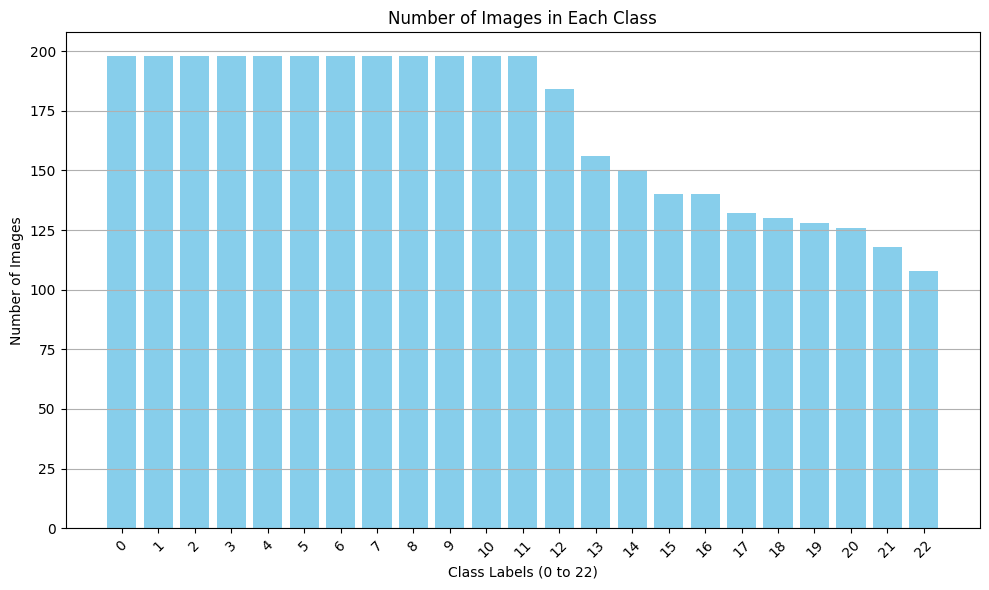

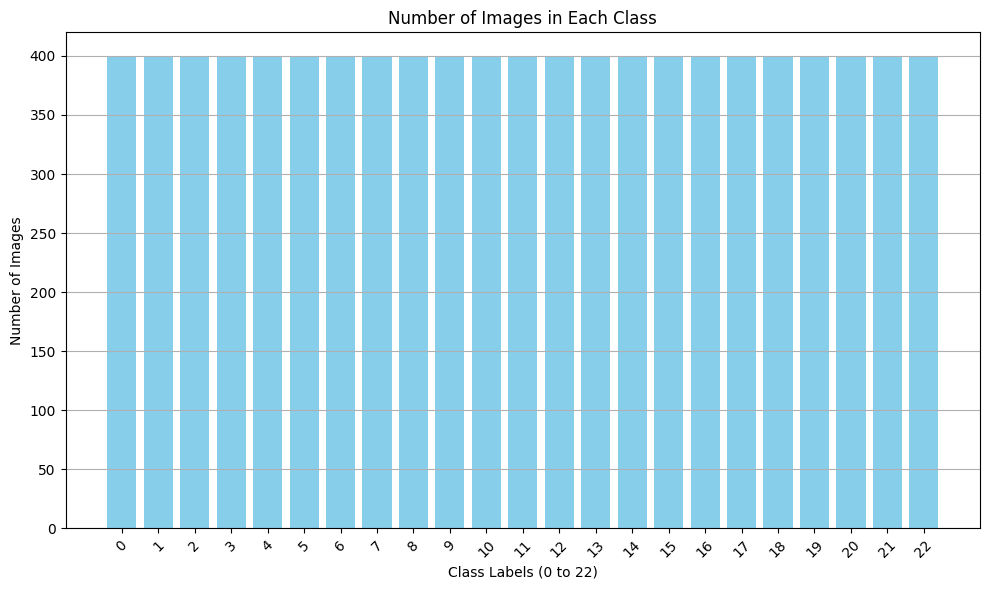

In [10]:
dataset_directory = "../experimental/data_classes"
balanced_directory = "../experimental/balanced_data_classes"

even_out_class_size(dataset_directory, balanced_directory)
plot_number_of_images(file_path=balanced_directory)

top_up_images(balanced_directory)
plot_number_of_images(file_path=balanced_directory)

### Visualising the data object we created

Found 4896 files belonging to 23 classes.


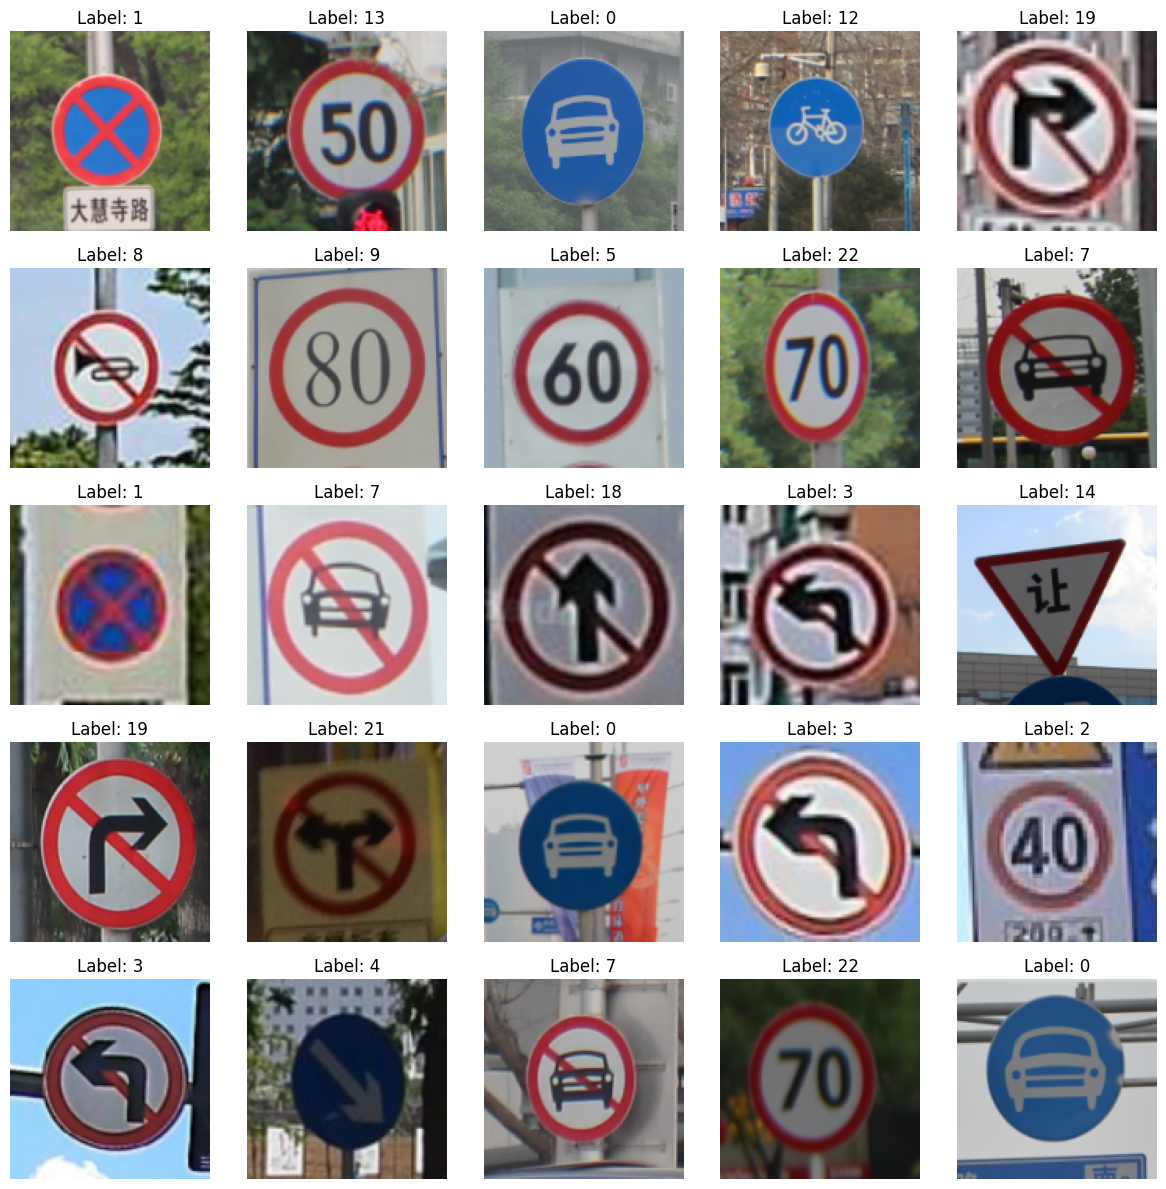

In [5]:
data=load_and_remap_and_normalise_dataset("../experimental/data_classes")
data_iterator= data.as_numpy_iterator()
batch=data_iterator.next()
display_batch(batch[0], batch[1], num_images=25)

### Visualising the dataset post augmentation


Found 9200 files belonging to 23 classes.


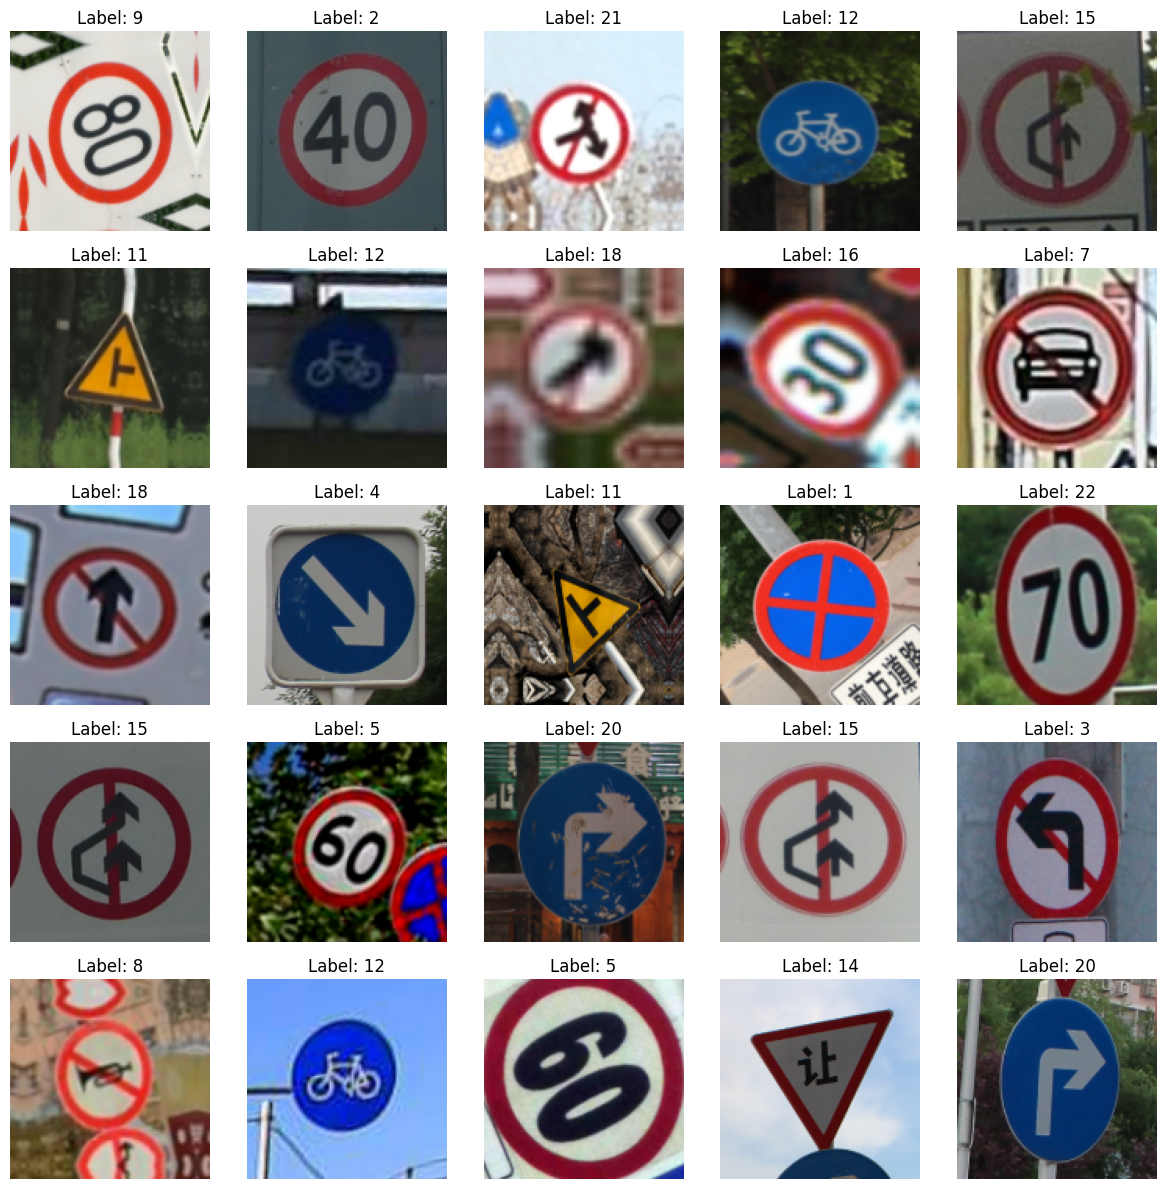

In [6]:
augmented_data_path="../experimental/balanced_data_classes"
augmented_data=load_and_remap_and_normalise_dataset(augmented_data_path)
augmented_data_iterator= augmented_data.as_numpy_iterator()
augmented_batch=augmented_data_iterator.next()
display_batch(augmented_batch[0], augmented_batch[1], num_images=25)

### Now we can see, each batch is much more uniformly distributed


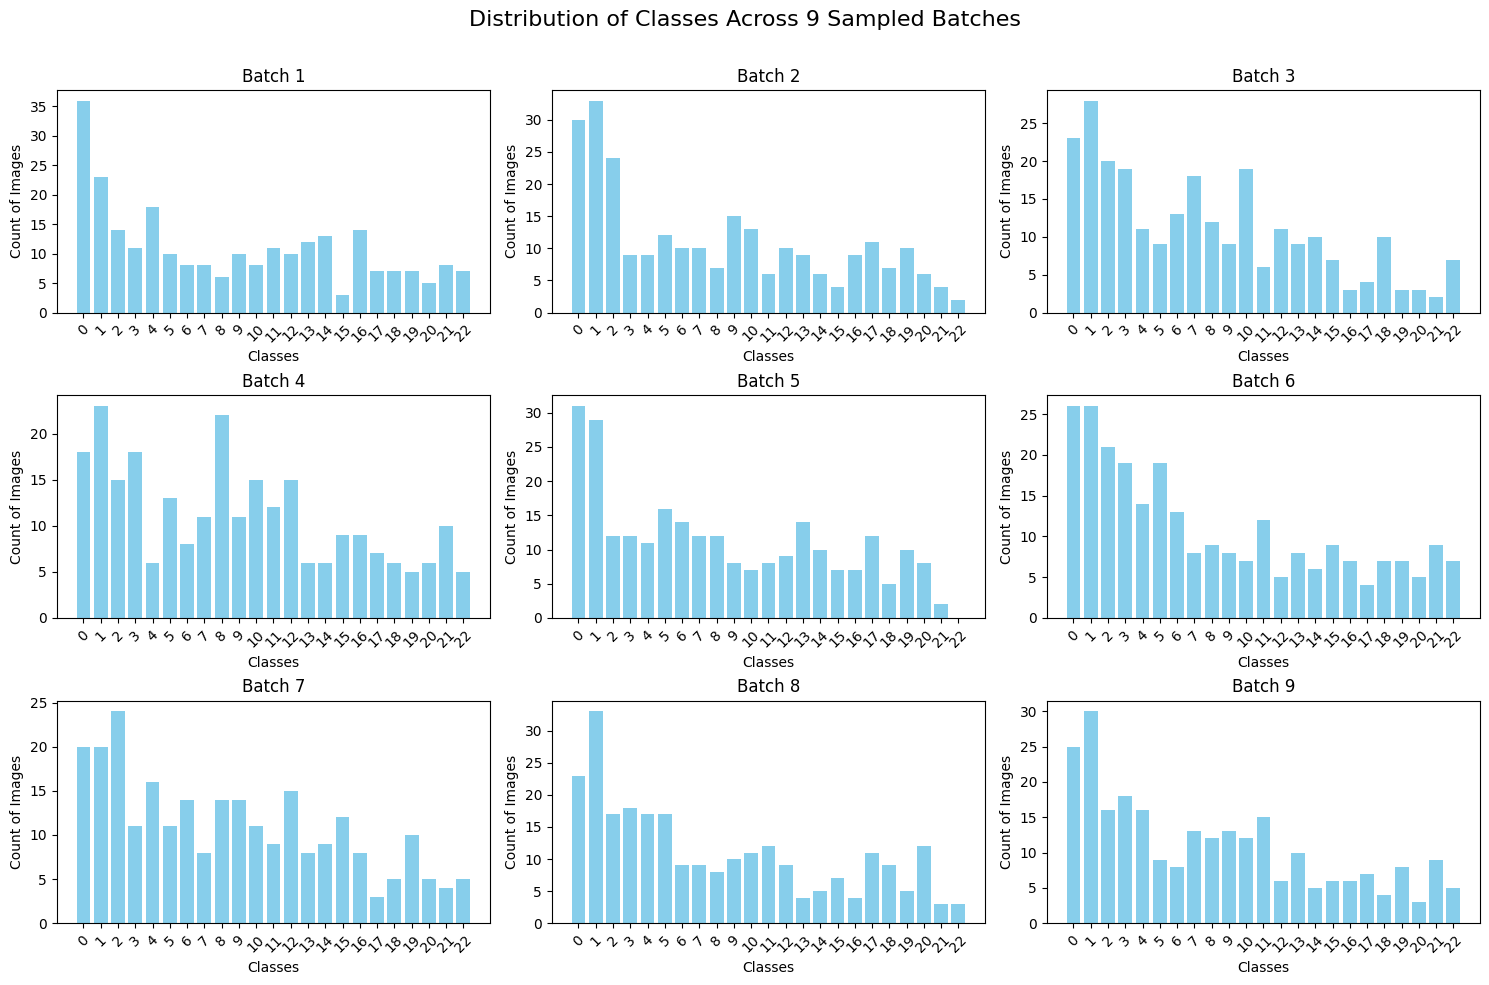

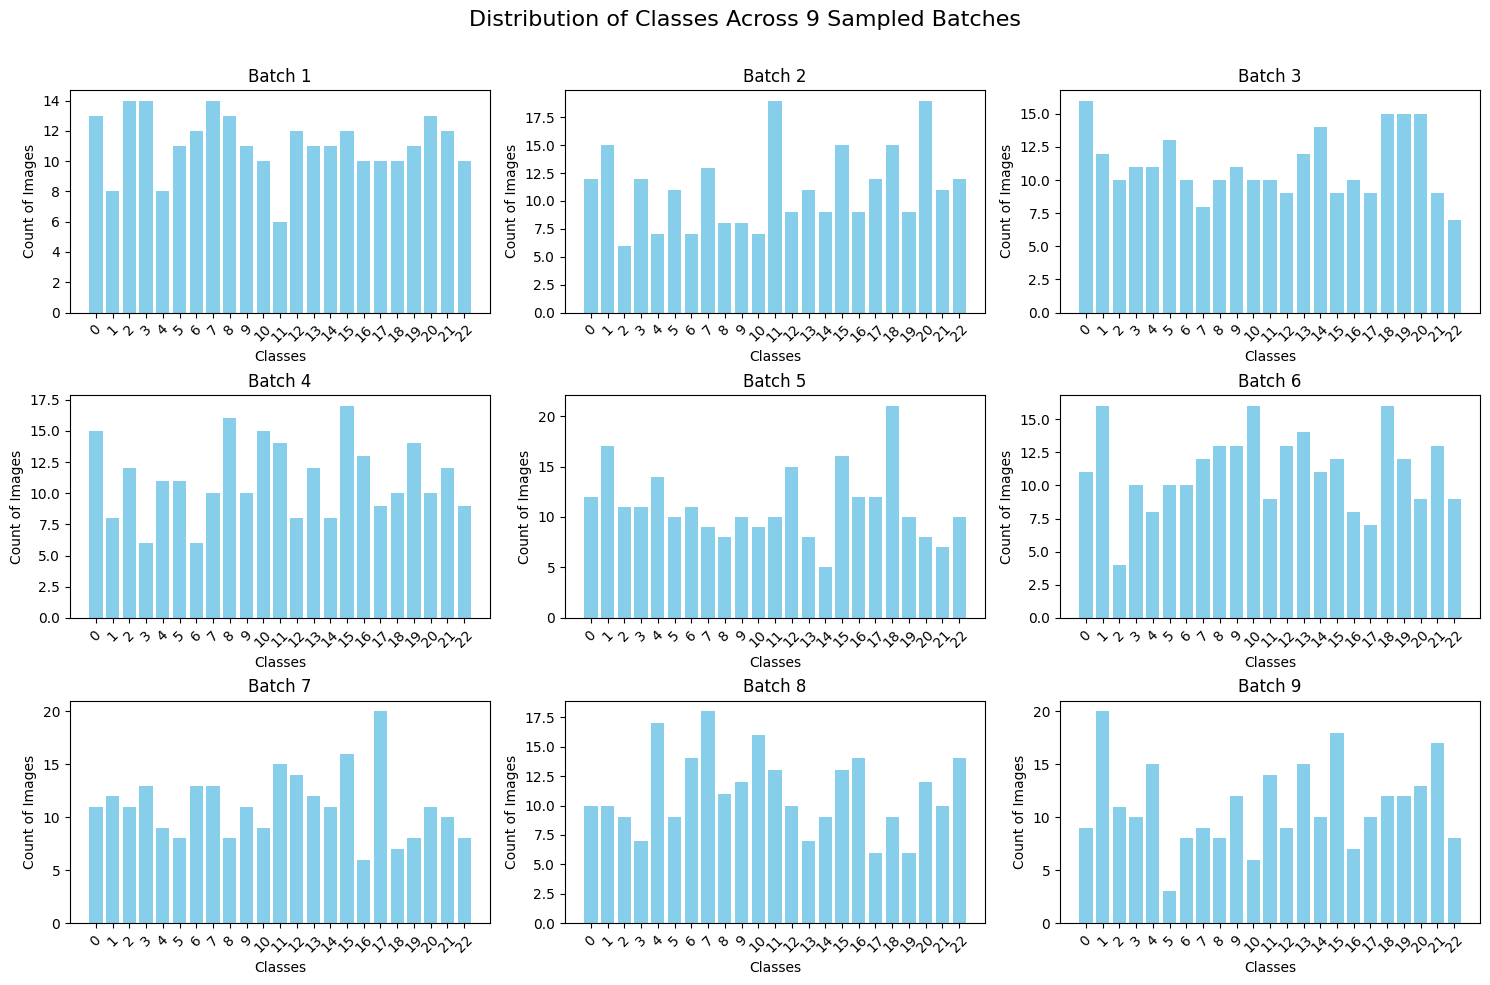

In [99]:
batch_counts = count_classes_in_sampled_batches(data)
augmented_batch_count = count_classes_in_sampled_batches(augmented_data)

### Now that data augmentation and initial EDA is done, we can create our train, test, and validation sets

To ensure that our model has enough data for effective learning, we chose the following commonly used proportions for splitting the dataset:

- **Train Set: 70%** - This set is used to train the model and learn the underlying patterns in the data.
- **Validation Set: 20%** - This set is used during model training to tune hyperparameters and monitor for overfitting.
- **Test Set: 10%** - This set is used to evaluate the final performance of the model and ensure that it generalizes well to unseen data.

These proportions strike a balance between providing the model with sufficient training data while also reserving enough samples for reliable evaluation and fine-tuning.

In [11]:
numBatch=len(data)
trainsize=int(0.7*numBatch)
valsize=int(0.2*numBatch)+1
testsize=int(0.1*numBatch)+1


train=data.take(trainsize)
val=data.skip(trainsize).take(valsize)
test=data.skip(trainsize+valsize).take(testsize)

print(len(train))
print(len(val))
print(len(test))


14
5
1


In [12]:
numBatch_augmented=len(augmented_data)
augmented_trainsize=int(0.7*numBatch_augmented)
augmented_valsize=int(0.2*numBatch_augmented)+1
augmented_testsize=int(0.1*numBatch_augmented)+1


augmented_train=augmented_data.take(augmented_trainsize)
augmented_val=augmented_data.skip(augmented_trainsize).take(augmented_valsize)
augmented_test=augmented_data.skip(augmented_trainsize+augmented_valsize).take(augmented_testsize)

print(len(augmented_train))
print(len(augmented_val))
print(len(augmented_test))

25
8
3


### Load in History Details

For plotting and running testing code, we will be loading in the accuracy and loss for previously trained models

In [111]:

with open("history/MobileNetV2_history.json", "r") as f:
    history_MobileNetV2 = json.load(f)
with open("history/complex_cnn_history.json", "r") as f:
    history_complex_cnn = json.load(f)
with open("history/shallow_model_history.json", "r") as f:
    history_shallow= json.load(f)
with open("history/ResNet50_history.json", "r") as f:
    history_ResNet50= json.load(f)
with open("history/finetuned_MobileNetV2_history.json", "r") as f:
    history_finetuned_MobileNet= json.load(f)
with open("history/vanilla_history.json", "r") as f:
    history_vanilla= json.load(f)

### The list of custom callbacks we will be using:


#### EarlyStopping: 

- This callback monitors a specified metric during training (in this case, val_loss) and stops the training process if there is no improvement in that metric for a certain number of epochs (defined by patience).

#### ReduceLROnPlateau:  

- This callback reduces the learning rate when a monitored metric has stopped improving. This can help the model converge more effectively by allowing it to take smaller steps in weight space when it is close to a local minimum.

#### TensorBoard:

- This callback enables logging of training metrics and model graphs to visualize the training process and monitor performance over time. TensorBoard provides a suite of visualization tools to better understand and debug the training process.

In [14]:
def create_callbacks(log_dir):
    """
    Create a list of Keras callbacks.

    Parameters:
    - dog_dir (str): Directory for TensorBoard logs.

    Returns:
    - list: A list of Keras callback instances.
    """
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
        TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]
    return callbacks

## Model Training and Evaluation

### [Model Training] Deep CNN Model Trained On Non Augmented Data

We first try to get a rough estimate on how the model classifies non-augmented data

In [101]:
vanilla_model=Sequential()

vanilla_model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(128,128,3)))
vanilla_model.add(MaxPooling2D())
vanilla_model.add(Conv2D(32, (3,3), 1, activation='relu'))
vanilla_model.add(MaxPooling2D())
vanilla_model.add(Conv2D(16, (3,3), 1, activation='relu'))
vanilla_model.add(MaxPooling2D())
vanilla_model.add(Flatten())
vanilla_model.add(Dense(256, activation='relu'))
vanilla_model.add(Dense(23, activation='softmax'))

vanilla_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

vanilla_model.summary()

vanilla_logdir='logs/logs_vanilla'

vanilla_hist = vanilla_model.fit(train, batch_size=64, epochs=200, validation_data=val, callbacks=create_callbacks(vanilla_logdir), verbose=1)
vanilla_model.save("../experimental/models/vanilla_model.keras")

with open("history/vanilla_history.json", "w") as f:
    json.dump(vanilla_hist.history, f)

/Users/sydneysim/Documents/Y2S1/IT1244/project/IT1244_Project/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 23)             │         5,911 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 818,695 (3.12 MB)

 Trainable params: 818,695 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 711ms/step - accuracy: 0.1501 - loss: 2.9682 - val_accuracy: 0.3797 - val_loss: 2.2701 - learning_rate: 0.0010
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 761ms/step - accuracy: 0.4631 - loss: 1.9347 - val_accuracy: 0.6555 - val_loss: 1.2184 - learning_rate: 0.0010
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 687ms/step - accuracy: 0.6650 - loss: 1.0824 - val_accuracy: 0.7859 - val_loss: 0.7505 - learning_rate: 0.0010
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 648ms/step - accuracy: 0.7843 - loss: 0.7124 - val_accuracy: 0.8492 - val_loss: 0.4823 - learning_rate: 0.0010
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 681ms/step - accuracy: 0.8653 - loss: 0.4536 - val_accuracy: 0.9039 - val_loss: 0.3146 - learning_rate: 0.0010
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 741ms/step - accuracy: 0.9160 - loss: 0.2935 - val_accuracy: 0.9461 - val_loss: 0.2023 - learning_rate: 0.0010
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 708ms/step - accuracy: 0.9469 - l

### [Model Testing and Evaluation] Tesing of Deep CNN Model Trained On Non Augmented Data

A simple model performs perfectly with non augmented data, with a perfect accuracy and no misclassifications!

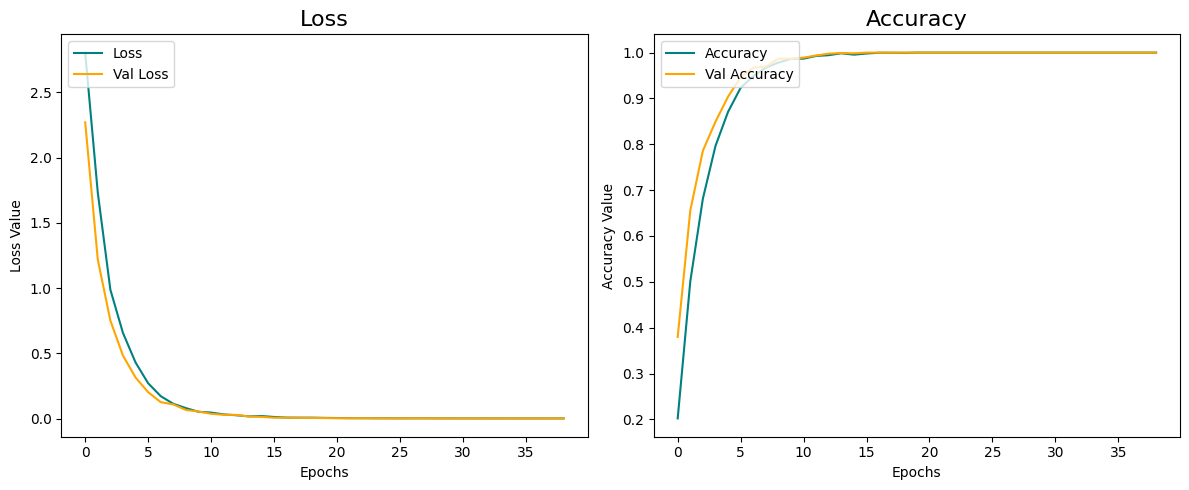

Misclassification counts:
{}

F1 Score:
{6: 0.0, 10: 1.0}

Accuracy:
1.00

 Number of Misclassifications: 
0


In [112]:
plot_loss_and_accuracy(history_vanilla)
reconstructed_vanilla_model=keras.models.load_model("../experimental/models/vanilla_model.keras") 
misclassified_vanilla = get_misclassifications(reconstructed_vanilla_model, test)

## However, lets do some investigation. Will This model be robust in real driving conditions?

Pictures will not always be perfect on the road, there would be variations in brightness, signs could be seen from different angles, and factors such as rain and fog could add noise to the image, leading to a much lower model accuracy.

We now test the model on the augmented dataset to simulate said conditions:
- Random Brightness is added to simulate varying light conditions
- Random Rotations are added to simulate the differnt angles that signs could be seen from
- Random Zoom is added to simulate different distances of signs
- Random Gausian Noise is added to factor in weather conditions that may impede camera image quality, i.e, rain and fog



### [Model Testing and Evaluation] Tesing of Deep CNN Model Tested On Augmented Data

Now that we factor these things in, we can see a stark drop in accuracy of the base model


In [107]:
misclassified_augmented_vanilla = get_misclassifications(reconstructed_vanilla_model, augmented_test)

Misclassification counts:
{'13': {'15': 1, '2': 2, '14': 2, '10': 1, '16': 1, '9': 2, '17': 3, '7': 2, '5': 1}, '16': {'5': 3, '2': 3, '9': 1, '17': 2, '14': 3, '7': 1}, '5': {'2': 5, '16': 1, '14': 1, '11': 1, '3': 1, '17': 1, '9': 1}, '7': {'5': 3, '11': 1, '15': 2, '4': 1, '3': 1, '14': 1}, '20': {'12': 3, '0': 4, '16': 1, '4': 4}, '8': {'14': 3, '17': 2, '5': 1, '15': 5, '7': 1, '21': 1}, '22': {'14': 1, '2': 5, '17': 3, '13': 1, '5': 2, '3': 1, '16': 2}, '1': {'0': 1, '12': 2, '3': 1, '20': 1}, '17': {'5': 4, '7': 1, '16': 1, '0': 1, '9': 1, '2': 1, '13': 1}, '2': {'17': 3, '14': 1, '9': 1, '15': 1, '5': 4, '7': 1, '16': 1}, '3': {'7': 3, '19': 2, '17': 3, '14': 1, '4': 1, '15': 3, '18': 1}, '21': {'14': 1, '17': 2, '15': 5, '5': 2, '3': 2, '2': 3, '13': 1}, '18': {'3': 4, '2': 6, '15': 2, '7': 2, '8': 1, '5': 1}, '10': {'6': 2, '11': 3}, '15': {'7': 6, '5': 5, '17': 2, '14': 1}, '14': {'7': 1, '6': 1, '13': 2, '9': 2, '1': 1, '5': 2, '2': 1, '8': 1}, '9': {'17': 1, '14': 3, '2': 

### [Model Training] Shallow CNN Model Trained On Non Augmented Data

Lets start training our first model on the larger, augmented dataset. We start off with a shallow model with only 1 convolutional layer, to act as a baseline for model performance. 

In [54]:
shallow_model=Sequential()
shallow_model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(128,128,3)))
shallow_model.add(MaxPooling2D())
shallow_model.add(Flatten())
shallow_model.add(Dense(32, activation='relu')) 
shallow_model.add(Dense(23, activation='softmax'))

shallow_model.summary()

shallow_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

logdir_augmented='logs/logs_shallow'

hist_shallow = shallow_model.fit(augmented_train, batch_size=16, epochs=100, validation_data=augmented_val, callbacks=create_callbacks(logdir_augmented), verbose=1)

shallow_model.save("../experimental/models/shallow_model.keras")

with open("history/shallow_model_history.json", "w") as f:
    json.dump(hist_shallow.history, f)


/Users/sydneysim/Documents/Y2S1/IT1244/project/IT1244_Project/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 63504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │     2,032,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 23)             │           759 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,033,367 (7.76 MB)

 Trainable params: 2,033,367 (7.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 740ms/step - accuracy: 0.0653 - loss: 5.2328 - val_accuracy: 0.1138 - val_loss: 2.9011 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 709ms/step - accuracy: 0.1299 - loss: 2.8500 - val_accuracy: 0.1855 - val_loss: 2.6992 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 508ms/step - accuracy: 0.1991 - loss: 2.6512 - val_accuracy: 0.2446 - val_loss: 2.5251 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 399ms/step - accuracy: 0.2755 - loss: 2.4322 - val_accuracy: 0.3340 - val_loss: 2.2572 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - accuracy: 0.3472 - loss: 2.1878 - val_accuracy: 0.4141 - val_loss: 2.0459 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 392ms/step - accuracy: 0.4427 - loss: 1.9419 - val_accuracy: 0.4565 - val_loss: 1.8498 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 401ms/step - accuracy: 0.5062 - l

### [Model Testing and Evaluation] Tesing of Shallow CNN Model Tested On Augmented Data

Things are looking much better, even a shallow model like with one convolutional block is able to achieve almost 0.9 accuracy. However, even 10 percent of misclassifications could result in dangerous situations on the road. How much more could we bring this number down?


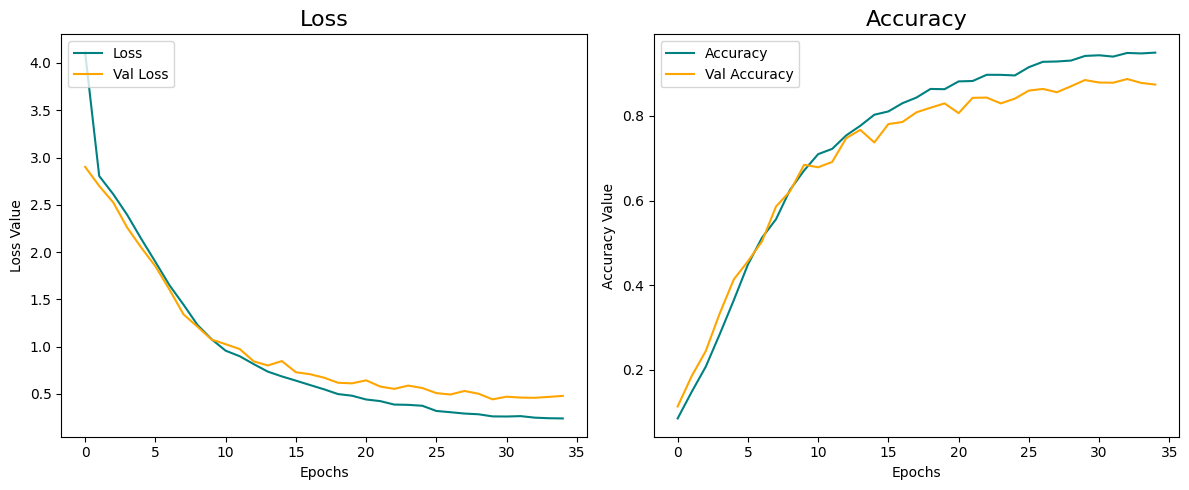

Misclassification counts:
{'5': {'2': 7, '22': 2, '9': 7, '13': 1, '7': 1, '17': 1, '8': 1}, '15': {'7': 1, '8': 1, '19': 2, '10': 1, '18': 1}, '2': {'13': 2, '5': 5, '22': 3, '16': 1}, '7': {'15': 2, '3': 1}, '12': {'0': 2}, '13': {'17': 1, '16': 1, '5': 3, '9': 2}, '16': {'14': 1, '22': 1, '13': 1, '5': 1}, '19': {'15': 2, '17': 2, '8': 1, '3': 1, '22': 1}, '22': {'17': 2}, '14': {'22': 1, '6': 1, '16': 2, '18': 1}, '18': {'2': 1, '3': 2, '15': 1, '14': 2}, '3': {'19': 1, '8': 1, '18': 1}, '6': {'10': 1}, '0': {'12': 1}, '20': {'0': 1, '4': 1}, '8': {'18': 1, '14': 1}, '9': {'16': 1}, '21': {'19': 1}, '1': {'6': 1}, '10': {'11': 1}, '17': {'2': 1}}

F1 Score:
{6: 0.9620253164556962, 10: 0.9491525423728814}

Accuracy:
0.88

 Number of Misclassifications: 
87


In [113]:
plot_loss_and_accuracy(history_shallow)
reconstructed_shallow_model=keras.models.load_model("../experimental/models/shallow_model.keras") 
misclassified_test_shallow = get_misclassifications(reconstructed_shallow_model, augmented_test)

## Theory: More Complexity=More accuracy?

In the field of machine learning and deep learning, there is a prevailing theory that suggests increasing the complexity of a model can lead to improved accuracy. This theory is based on the idea that more complex models, which may include additional layers, neurons, or advanced architectures, can better capture intricate patterns within the data.

### [Model Training] Deeper CNN Model Trained On Augmented Data

To test out this theory, we take the shallow model, and throw on some complexity in the form of more convolutional layers. This deeper model will now have 3 convolutional layers instead of 1. 

In [56]:
augmented_model=Sequential()

augmented_model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(128,128,3)))
augmented_model.add(MaxPooling2D())
augmented_model.add(Conv2D(32, (3,3), 1, activation='relu'))
augmented_model.add(MaxPooling2D())
augmented_model.add(Conv2D(16, (3,3), 1, activation='relu'))
augmented_model.add(MaxPooling2D())
augmented_model.add(Flatten())
augmented_model.add(Dense(256, activation='relu'))
augmented_model.add(Dense(23, activation='softmax'))


augmented_model.summary()

augmented_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

logdir_augmented='logs/logs_augmented'

hist_augmented = augmented_model.fit(augmented_train, batch_size=16, epochs=100, validation_data=augmented_val, callbacks=create_callbacks(logdir_augmented), verbose=1)

augmented_model.save("../experimental/models/augmented_model.keras")

with open("history/complex_cnn_history.json", "w") as f:
    json.dump(hist_augmented.history, f)

/Users/sydneysim/Documents/Y2S1/IT1244/project/IT1244_Project/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 23)             │         5,911 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 818,695 (3.12 MB)

 Trainable params: 818,695 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 645ms/step - accuracy: 0.1698 - loss: 2.8721 - val_accuracy: 0.4263 - val_loss: 1.8326 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 650ms/step - accuracy: 0.5071 - loss: 1.6425 - val_accuracy: 0.6182 - val_loss: 1.1976 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 652ms/step - accuracy: 0.6800 - loss: 1.0737 - val_accuracy: 0.7451 - val_loss: 0.8558 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 653ms/step - accuracy: 0.7860 - loss: 0.7160 - val_accuracy: 0.8140 - val_loss: 0.6385 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 676ms/step - accuracy: 0.8437 - loss: 0.5303 - val_accuracy: 0.8213 - val_loss: 0.5740 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 684ms/step - accuracy: 0.8836 - loss: 0.4044 - val_accuracy: 0.8789 - val_loss: 0.4108 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 708ms/step - accuracy: 0.9122 - l

### [Model Testing and Evaluation] Testing of Deep CNN Model Tested On Augmented Data

Wow! There was a stark increase in model accuracy, bringing the model from 0.88 to a 0.96 accuracy, and decreasing misclassifications by over 70%, bringing the misclassifid images down from 87 to 27! How far will this theory hold?

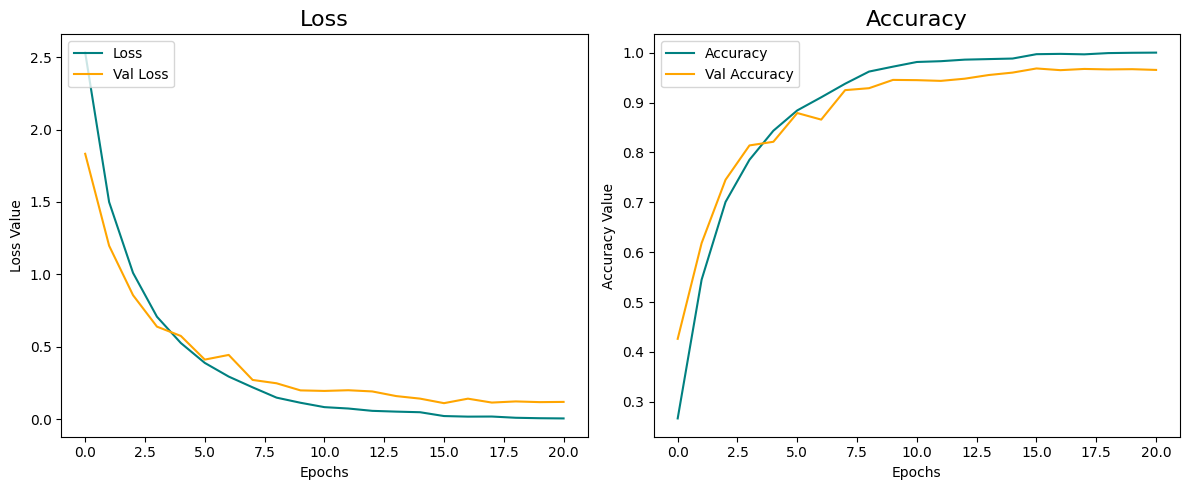

Misclassification counts:
{'5': {'2': 3, '9': 2}, '21': {'15': 1, '19': 1, '18': 1}, '13': {'9': 1, '22': 2}, '19': {'7': 1}, '4': {'0': 1}, '2': {'5': 2, '14': 1, '9': 2}, '11': {'10': 1}, '14': {'16': 2, '17': 1, '19': 1}, '7': {'18': 1}, '6': {'14': 1}, '18': {'21': 1}, '17': {'2': 1}}

F1 Score:
{6: 0.9836065573770492, 10: 0.9873417721518988}

Accuracy:
0.96

 Number of Misclassifications: 
27


In [116]:
plot_loss_and_accuracy(history_complex_cnn)
reconstructed_augmented_model=keras.models.load_model("../experimental/models/augmented_model.keras") 
misclassified_test = get_misclassifications(reconstructed_augmented_model, augmented_test)

### [Model Training] ResNet50 Trained on Augmented Data

Let’s now push the boundaries of the theory that more complexity leads to higher accuracy. ResNet50 is a powerful pretrained model featuring 50 layers and containing over 20 million parameters. Its architecture incorporates residual connections, which help mitigate the vanishing gradient problem that can occur in very deep networks. This design enables the model to learn intricate features and patterns from data effectively.

Given its complexity, if our theory holds true, we should expect to see exceptionally high accuracy when training ResNet50 on a well-prepared dataset, especially one that has undergone augmentation techniques. 

In [64]:
dnn_model = Sequential()
imported_model= tf.keras.applications.ResNet50(include_top=False,input_shape=(128,128,3),pooling='avg',classes=23,weights='imagenet')
for layer in imported_model.layers:
    layer.trainable=False

dnn_model.add(imported_model)
dnn_model.add(Flatten())
dnn_model.add(Dense(512, activation='relu'))
dnn_model.add(Dense(23, activation='softmax'))

dnn_model.summary()

dnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

dnn_logdir="logs/logs_dnn"

dnn_model_history = dnn_model.fit(augmented_train, batch_size=16, epochs=100, validation_data=augmented_val, callbacks=create_callbacks(dnn_logdir), verbose=1)

dnn_model.save("../experimental/models/dnn_model.keras") #save completed model after training

with open("history/ResNet50_history.json", "w") as f:
    json.dump(dnn_model_history.history, f)




Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 23)             │        11,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,648,599 (94.03 MB)

 Trainable params: 1,060,887 (4.05 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.0658 - loss: 3.1828 - val_accuracy: 0.1118 - val_loss: 2.9995 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.1298 - loss: 2.9680 - val_accuracy: 0.1489 - val_loss: 2.8946 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 114s 5s/step - accuracy: 0.1622 - loss: 2.8678 - val_accuracy: 0.1611 - val_loss: 2.8128 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 120s 5s/step - accuracy: 0.1866 - loss: 2.7746 - val_accuracy: 0.1978 - val_loss: 2.7192 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 116s 5s/step - accuracy: 0.2172 - loss: 2.6905 - val_accuracy: 0.2075 - val_loss: 2.6582 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.2436 - loss: 2.6316 - val_accuracy: 0.2827 - val_loss: 2.5804 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.2736 - loss: 2.5586 - 

### [Model Testing and Evaluation] Testing of ResNet50 On Augmented Data

Contrary to our expectations, this model underperformed severely! It was not able to achieve even 0.6 accuracy, while having the largest number of miscalculations of all models so far!

#### Possible Explanations:

2. **Small or Poor Quality Dataset**: A small dataset limits the model's ability to learn effectively, as it may not capture enough variability. Additionally, if the dataset contains low-quality or noisy data, such as mislabeled images or irrelevant features, this can lead to poor learning outcomes.

3. **Inappropriate Model Architecture**: ResNet50 may not be the best choice for the specific dataset or problem. If the features of the dataset do not align with what the model is designed to recognize, the model will struggle regardless of training time.


The unexpectedly low accuracy of ResNet50 on augmented data prompts a reevaluation of our initial theory.

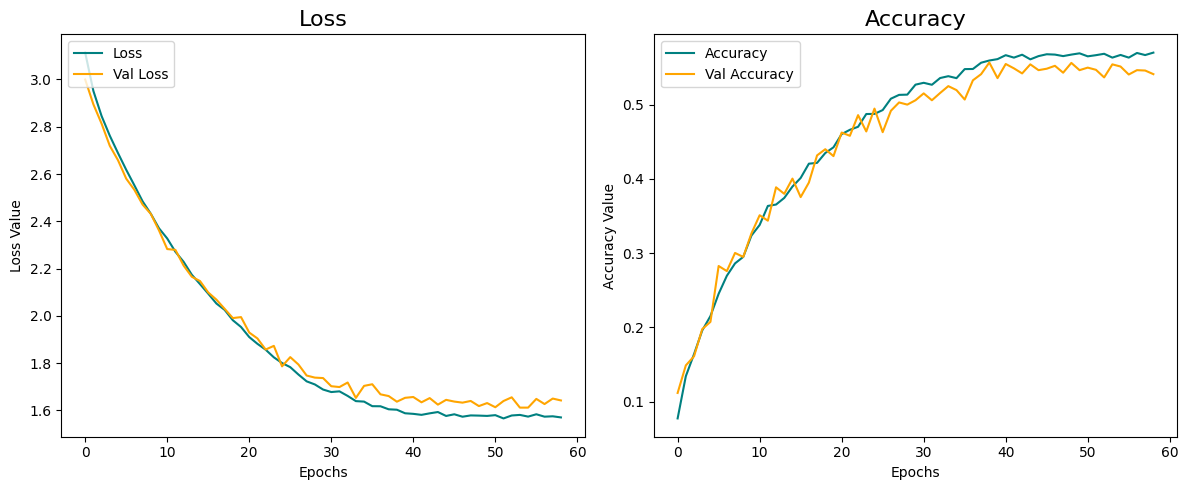

Misclassification counts:
{'11': {'1': 2, '10': 10, '12': 1, '14': 4}, '20': {'14': 2, '11': 2, '10': 1, '4': 2, '1': 6, '0': 2, '19': 2, '12': 1}, '3': {'0': 1, '6': 1, '1': 2, '21': 2, '14': 2, '15': 1, '5': 1, '17': 2}, '9': {'0': 2, '22': 3, '16': 1, '11': 1, '2': 2, '13': 2, '6': 2, '8': 1, '12': 1, '1': 1}, '10': {'11': 5, '9': 1, '1': 4, '0': 1, '2': 1, '4': 2}, '4': {'1': 4, '11': 3, '17': 1, '20': 8, '10': 1, '12': 1, '19': 1, '14': 1}, '13': {'6': 2, '16': 4, '2': 5, '8': 1, '22': 4, '19': 2, '5': 1, '17': 2, '21': 1, '1': 1}, '0': {'12': 11, '17': 1, '20': 1, '4': 1, '10': 1, '11': 1, '1': 1, '6': 1}, '2': {'19': 1, '22': 4, '16': 1, '5': 3, '18': 1, '13': 3, '7': 3, '11': 1, '4': 2, '9': 2, '8': 1, '12': 1}, '18': {'15': 1, '17': 2, '21': 2, '16': 2, '19': 1, '13': 1}, '19': {'14': 6, '15': 1, '7': 3, '17': 1, '16': 3, '20': 1, '3': 3, '11': 2, '18': 2, '22': 1, '0': 1, '6': 1}, '17': {'15': 1, '4': 1, '19': 2, '5': 1, '11': 1, '21': 2, '7': 1, '3': 1}, '1': {'20': 3, '4': 

In [117]:
plot_loss_and_accuracy(history_ResNet50)
reconstructed_dnn_augmented_model=keras.models.load_model("../experimental/models/dnn_model.keras") 
dnn_misclassifications = get_misclassifications(reconstructed_dnn_augmented_model, augmented_test)

### [Model Training] MobileNetV2 Trained on Augmented Data

Was the previous model too much for our purposes/data? We now change to a fresh approach: MobileNetV2, a lightweight model specifically designed for mobile and edge devices. MobileNetV2 is less complex than ResNet50 but retains a strong capacity for feature extraction, making it an excellent choice for tasks with limited data.

#### Rationale for Choosing MobileNetV2:
1. **Efficiency**: MobileNetV2 is designed to be computationally efficient, making it suitable for applications where resources are constrained. This efficiency does not compromise performance on visual recognition tasks.
   
2. **Reduced Overfitting Risk**: Given the smaller dataset we are working with, using a less complex model like MobileNetV2 reduces the risk of overfitting. Its architecture allows it to learn meaningful features without memorizing the training data.

3. **Transfer Learning**: We will leverage transfer learning by using pretrained weights from ImageNet. This allows the model to start with a solid foundation of learned features, which can be fine-tuned for our specific dataset.



In [58]:
imported_model_mobilenet = Sequential()

imported_model= tf.keras.applications.MobileNetV2(
    include_top=False,           
    input_shape=(128, 128, 3),    
    pooling='avg',               
    weights='imagenet'            
)

# Freeze the layers of the imported model
for layer in imported_model.layers:
    layer.trainable = False

# Add the MobileNetV2 model to our Sequential model
imported_model_mobilenet.add(imported_model)

# Add custom layers for classification
imported_model_mobilenet.add(Flatten())
imported_model_mobilenet.add(Dense(512, activation='relu'))
imported_model_mobilenet.add(Dense(23, activation='softmax'))  # Assuming 23 output classes

# Show the model summary
imported_model_mobilenet.summary()

imported_model_mobilenet.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy',      
    metrics=['accuracy']
)

logs_mobile_net="logs/logs_mobile_net"

mobilenet_history = imported_model_mobilenet.fit(
    augmented_train,                          
    validation_data=augmented_val,          
    epochs=100,                        
    callbacks=create_callbacks(logs_mobile_net) 
)

imported_model_mobilenet.save("../experimental/models/mobile_net_model.keras") #save completed model after training


with open("history/MobileNetV2_history.json", "w") as f:
    json.dump(mobilenet_history.history, f)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 23)             │        11,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,925,655 (11.16 MB)

 Trainable params: 667,671 (2.55 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4795 - loss: 1.8751 - val_accuracy: 0.8599 - val_loss: 0.4377 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 992ms/step - accuracy: 0.9038 - loss: 0.3165 - val_accuracy: 0.9336 - val_loss: 0.2204 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9639 - loss: 0.1531 - val_accuracy: 0.9561 - val_loss: 0.1589 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9784 - loss: 0.1004 - val_accuracy: 0.9692 - val_loss: 0.1163 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9906 - loss: 0.0666 - val_accuracy: 0.9766 - val_loss: 0.1025 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9935 - loss: 0.0500 - val_accuracy: 0.9844 - val_loss: 0.0755 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9986 - loss: 0.0333 - val_

### [Model Testing and Evaluation] Testing of MobileNetV2 On Augmented Data

This model performs exceedingly well on our dataset, achieving almost an almost perfect accuracy of 0.99, with only 12 misclassifications, and most importantly, perfect F1 scores for out "positive" classes (As defined in the project report)

#### Key Observations:
1. **High Accuracy**: The near-perfect accuracy indicates that the model has successfully learned to distinguish between the classes in our dataset. This suggests that the features extracted by MobileNetV2 are highly relevant to our classification task.

2. **Low Misclassification Rate**: With only 12 instances misclassified, the model demonstrates its ability to generalize well from the training data to unseen validation data. This low misclassification rate is particularly encouraging, as it reflects the model's reliability in making predictions.

3. **F1 Score Performance**: Most importantly, the model achieves perfect F1 scores for our "positive" classes, as defined in the project report. This is crucial for tasks where precision and recall are both vital, indicating that the model not only identifies positive classes effectively but also minimizes false positives.

4. **Robustness to Augmented Data**: The positive impact of data augmentation techniques used during training is evident in the model's performance. The increased variety in the training data has helped the model to learn more robust features, enhancing its predictive capabilities.

Moving Forward: Could we somehow improve this model? How would we achieve a misclassification count of close to 0?

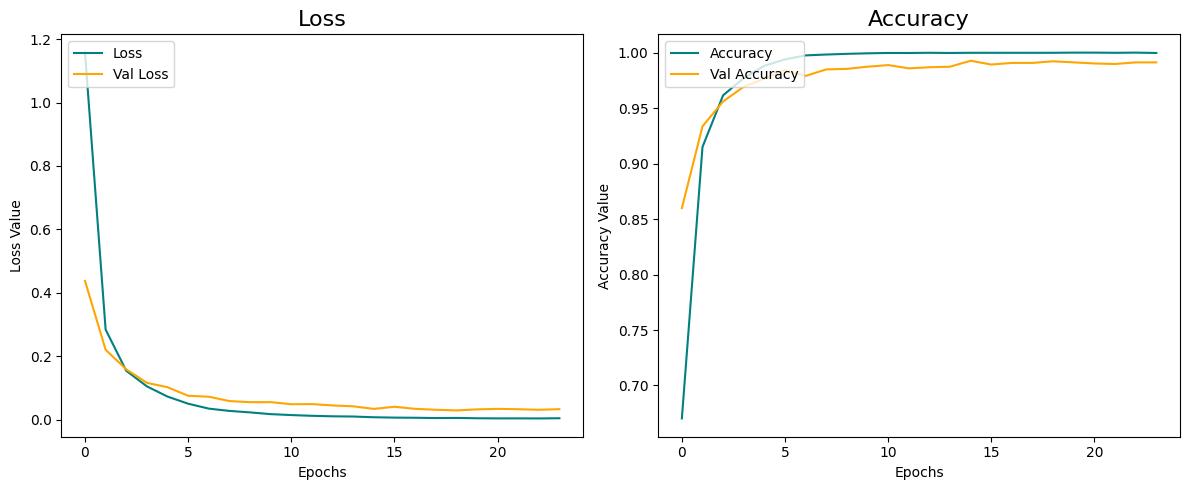

Misclassification counts:
{'2': {'16': 1, '8': 1}, '9': {'2': 1, '13': 1}, '8': {'15': 1}, '19': {'3': 1}, '15': {'8': 1}, '13': {'16': 1}, '5': {'9': 1}, '18': {'8': 1}, '12': {'17': 1}}

F1 Score:
{6: 1.0, 10: 1.0}

Accuracy:
0.99

 Number of Misclassifications: 
11


In [166]:
plot_loss_and_accuracy(history_MobileNetV2)
reconstructed_mobile_net_model=keras.models.load_model("../experimental/models/mobile_net_model.keras") 
mobile_net_misclassified_test = get_misclassifications(reconstructed_mobile_net_model, augmented_test)

### [Model Training] Fine Tuning MobileNetV2 Trained on Augmented Data

Our last approach to further perfecting this model involves fine-tuning the last few layers of our most promising architecture, MobileNetV2. Fine-tuning allows us to leverage the pretrained weights of MobileNetV2 while making it adaptable to our specific dataset, enhancing its performance further.

#### Key Steps in the Fine-Tuning Process:

1. **Unfreezing Layers**: By unfreezing the last few layers of MobileNetV2, we enable the model to adjust its weights based on the features learned during the initial training phase. This process allows the model to better capture the nuances of our dataset.

2. **Reduced Learning Rate**: During fine-tuning, we typically employ a lower learning rate to ensure that the model makes smaller adjustments to the weights. This helps prevent drastic changes that could disrupt the previously learned features.


By fine-tuning MobileNetV2, we aim to maximize the model's predictive capabilities and achieve even higher accuracy on our dataset. This process represents our commitment to refining our model and ensuring its effectiveness in real-world applications.

In [83]:
def create_special_callbacks(log_dir):
    """
    Create a list of Keras callbacks.

    Parameters:
    - dog_dir (str): Directory for TensorBoard logs.

    Returns:
    - list: A list of Keras callback instances.
    """
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7),
        TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]
    return callbacks

In [84]:
MobileNetV2_finetuned = Sequential()

mobile_net = tf.keras.applications.MobileNetV2(
    include_top=False,           
    input_shape=(128, 128, 3),    
    pooling='avg',               
    weights='imagenet'            
)

for layer in mobile_net.layers:
    layer.trainable = False

#This time we train the last 5 layers of the model
for layer in mobile_net.layers[-5:]:
    layer.trainable = True

MobileNetV2_finetuned.add(mobile_net)

MobileNetV2_finetuned.add(Flatten())
MobileNetV2_finetuned.add(Dense(512, activation='relu'))
MobileNetV2_finetuned.add(Dense(23, activation='softmax'))  

MobileNetV2_finetuned.summary()

MobileNetV2_finetuned.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='sparse_categorical_crossentropy',      
    metrics=['accuracy']
)

logs_finetuned_mobile_net = "logs/logs_finetuned_mobile_net"

finetuned_mobilenet_history = MobileNetV2_finetuned.fit(
    augmented_train,                          
    validation_data=augmented_val,          
    epochs=100,                        
    callbacks=create_special_callbacks(logs_finetuned_mobile_net)
)

MobileNetV2_finetuned.save("../experimental/models/finetuned_mobile_net_model.keras")


with open("history/finetuned_MobileNetV2_history.json", "w") as f:
    json.dump(finetuned_mobilenet_history.history, f)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 23)             │        11,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,925,655 (11.16 MB)

 Trainable params: 1,080,471 (4.12 MB)

 Non-trainable params: 1,845,184 (7.04 MB)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.3131 - loss: 2.6081 - val_accuracy: 0.6191 - val_loss: 1.4094 - learning_rate: 1.0000e-04
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7839 - loss: 0.9619 - val_accuracy: 0.7373 - val_loss: 0.9203 - learning_rate: 1.0000e-04
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8794 - loss: 0.5026 - val_accuracy: 0.8018 - val_loss: 0.6510 - learning_rate: 1.0000e-04
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9352 - loss: 0.3140 - val_accuracy: 0.8228 - val_loss: 0.5580 - learning_rate: 1.0000e-04
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9597 - loss: 0.2218 - val_accuracy: 0.8682 - val_loss: 0.4306 - learning_rate: 1.0000e-04
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9744 - loss: 0.1625 - val_accuracy: 0.8799 - val_loss: 0.3797 - learning_rate: 1.0000e-04
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9843 

### [Model Testing and Evaluation] Testing of Finetuned MobileNetV2 On Augmented Data

The fine-tuned MobileNetV2 model has exceeded our expectations, demonstrating remarkable performance on the augmented dataset. After undergoing fine-tuning, the model achieved a perfect accuracy score of 1.0, indicating that it correctly classified most test samples.

#### Key Highlights of the Evaluation:

1. **Exceptional Accuracy**: The fine-tuned model reached an accuracy of 1.0, which signifies that it perfectly predicted all labels in the test dataset. This level of performance indicates that the model has effectively learned to distinguish between the different classes present in the data.

2. **Low Misclassification Count**: With only 3 misclassifications, this model boasts the lowest count of misclassifications among all models tested. This indicates a strong ability to generalize well to unseen data, reducing the likelihood of errors in practical applications.



In conclusion, the fine-tuned MobileNetV2 has proven to be a powerful model for our dataset, achieving outstanding results and setting a high benchmark for future work in this area.


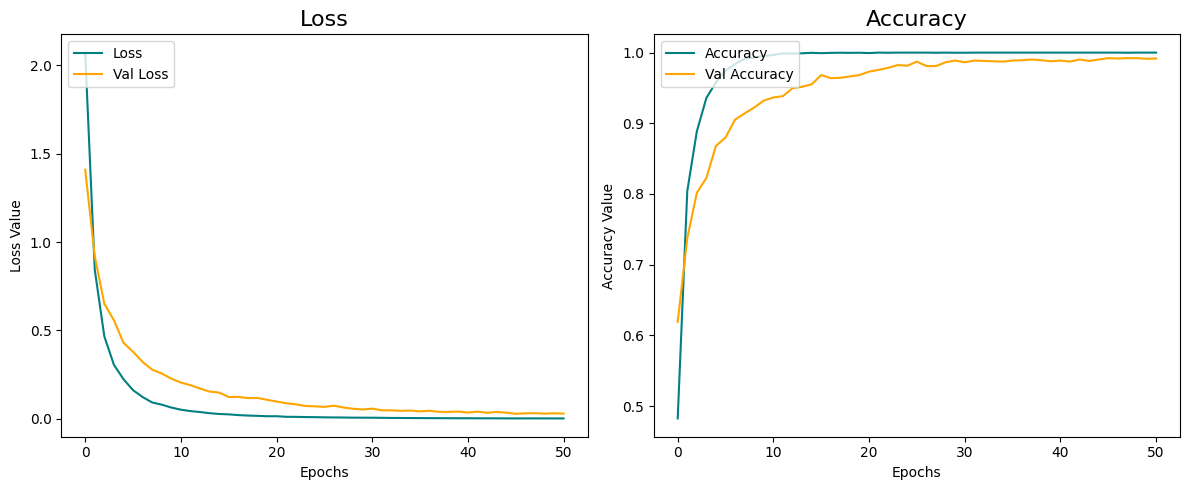

Misclassification counts:
{'21': {'19': 1}, '9': {'5': 1}, '16': {'2': 1}}

F1 Score:
{6: 1.0, 10: 1.0}

Accuracy:
1.00

 Number of Misclassifications: 
3


In [173]:
plot_loss_and_accuracy(history_finetuned_MobileNet)
reconstructed_finetuned_mobile_net_model=keras.models.load_model("../experimental/models/finetuned_mobile_net_model.keras") 
mobile_net_misclassified_test = get_misclassifications(reconstructed_finetuned_mobile_net_model, augmented_test)

### Final Visualisation: Comparative Plot of Validation accuracy of all models

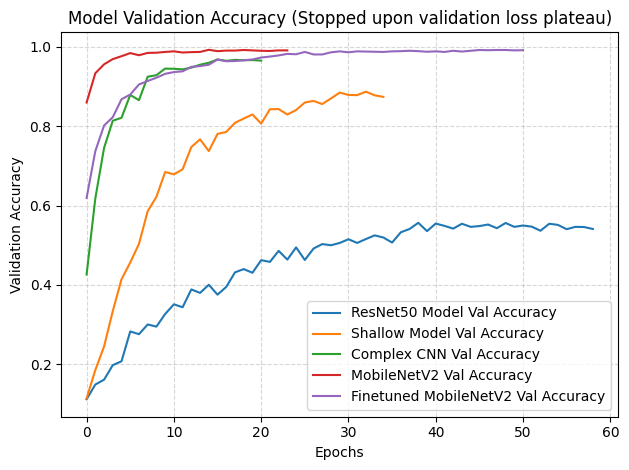

In [174]:

# ResNet50 Acccuracy
plt.plot(history_ResNet50['val_accuracy'], label='ResNet50 Model Val Accuracy', linestyle='-')

# Shallow model accuracy
plt.plot(history_shallow['val_accuracy'], label='Shallow Model Val Accuracy', linestyle='-')

# Complex CNN accuracy
plt.plot(history_complex_cnn['val_accuracy'], label='Complex CNN Val Accuracy', linestyle='-')

# MobileNetV2 accuracy
plt.plot(history_MobileNetV2['val_accuracy'], label='MobileNetV2 Val Accuracy', linestyle='-')

# Finetuned MobileNet accuracy
plt.plot(history_finetuned_MobileNet['val_accuracy'], label='Finetuned MobileNetV2 Val Accuracy', linestyle='-')



# Adding labels and legend
plt.title('Model Validation Accuracy (Stopped upon validation loss plateau)')
plt.xlabel('Epochs')
epoch_count = len(history_MobileNetV2['accuracy'])-20
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()